<ipython-input-1-dcb159b626df>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station['DATE'] = pd.to_datetime(df_station['DATE'], errors='coerce')


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.1620 - val_loss: 0.0119
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0284 - val_loss: 0.0098
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0253 - val_loss: 0.0098
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0227 - val_loss: 0.0100
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0241 - val_loss: 0.0101
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0202 - val_loss: 0.0103
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0186 - val_loss: 0.0099
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0192 - val_loss: 0.0101
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0197 - val_loss: 0.0099
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0207 - val_loss: 0.0100
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0212 - val_loss: 0.0120
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0177 - val_l

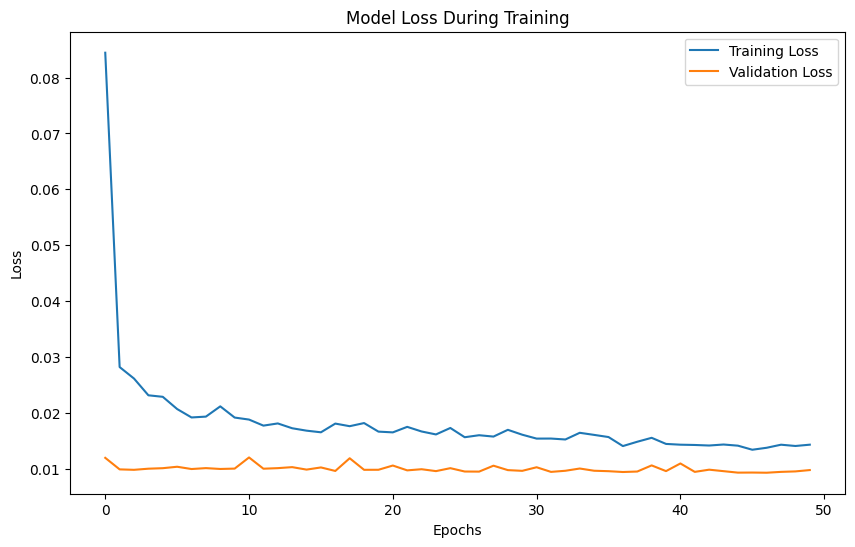

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


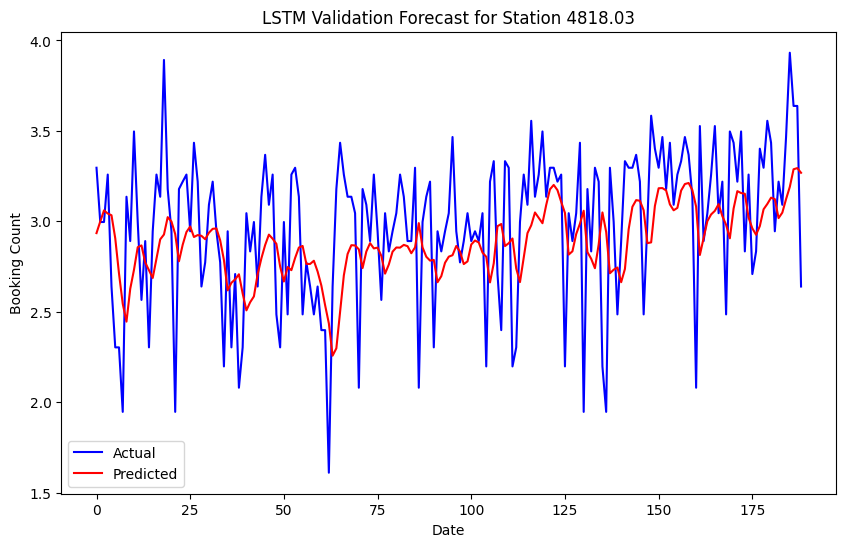

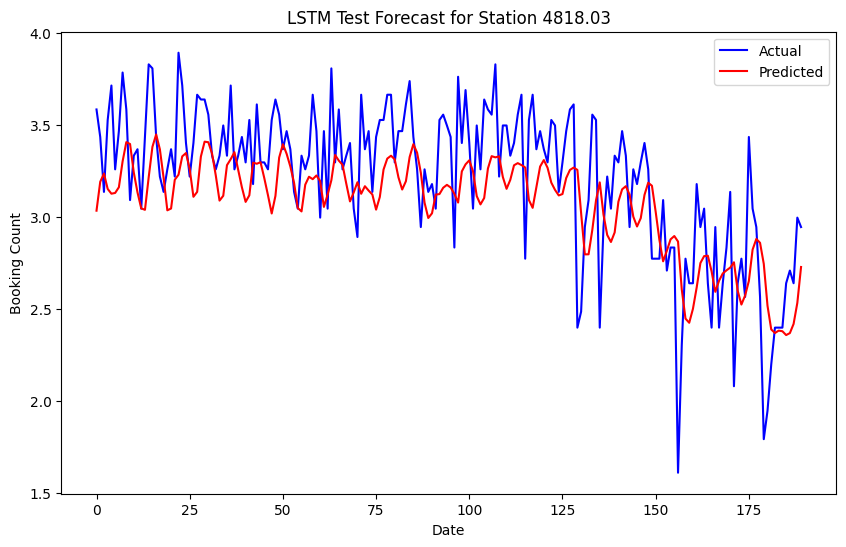

Validation Set Evaluation Metrics:
MSE: 0.1669660365078672
MAE: 0.3308719019937975
RMSE: 0.4086147776425459
MAPE: 11.812875602073772%

Test Set Evaluation Metrics:
MSE: 0.11189119160167751
MAE: 0.26953654059993537
RMSE: 0.33450140747338797
MAPE: 8.705883986403624%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the datasets
file_paths = [
    "/content/2021Citibike daily trip counts&weather.csv",
    "/content/2022Citibike daily trip counts&weather.csv",
    "/content/2023Citibike daily trip counts&weather.csv",
    "/content/2024Citibike daily trip counts&weather.csv",
    "/content/Final_Urban_Feaatures_Merged_csv.csv"
]

# Load each CSV file
df_2021 = pd.read_csv(file_paths[0], dtype={'start_station_id': str})
df_2022 = pd.read_csv(file_paths[1], dtype={'start_station_id': str})
df_2023 = pd.read_csv(file_paths[2], dtype={'start_station_id': str})
df_2024 = pd.read_csv(file_paths[3], dtype={'start_station_id': str})
df_urban = pd.read_csv(file_paths[4])

# Combine the Citibike trip data for all years
df = pd.concat([
    df_2021[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2022[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2023[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2024[['start_station_id', 'DATE', 'booking_count', 'TAVG']]
])

# Filter the data for station 4818.03 only
df_station = df[df['start_station_id'] == '4818.03']

# Convert 'DATE' to datetime format
df_station['DATE'] = pd.to_datetime(df_station['DATE'], errors='coerce')

# Use the 'TAVG' as the temperature column directly
df_station = df_station.dropna(subset=['booking_count', 'DATE'])

# Rename columns to match LSTM input format
df_station.rename(columns={'DATE': 'ds', 'booking_count': 'y', 'TAVG': 'temperature'}, inplace=True)

# Feature Engineering: Create 'day_of_week' and 'is_weekend' to capture weekly seasonality
df_station['day_of_week'] = df_station['ds'].dt.dayofweek
df_station['is_weekend'] = df_station['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Sort the data by 'ds' (date)
df_station = df_station.sort_values('ds')

# Apply log transformation (log(1+x)) to 'y' (booking count)
df_station['y'] = np.log1p(df_station['y'])

# Split data into training (70%), validation (15%), and test (15%)
train_size = int(0.7 * len(df_station))
val_size = int(0.15 * len(df_station))

train = df_station[:train_size]
validation = df_station[train_size:train_size + val_size]
test = df_station[train_size + val_size:]

# Normalize the 'y' values (booking_count) and other features (temperature, is_weekend)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_temp = MinMaxScaler(feature_range=(0, 1))
scaler_weekend = MinMaxScaler(feature_range=(0, 1))

train_scaled_y = scaler_y.fit_transform(train[['y']])
validation_scaled_y = scaler_y.transform(validation[['y']])
test_scaled_y = scaler_y.transform(test[['y']])

train_scaled_temp = scaler_temp.fit_transform(train[['temperature']])
validation_scaled_temp = scaler_temp.transform(validation[['temperature']])
test_scaled_temp = scaler_temp.transform(test[['temperature']])

train_scaled_weekend = scaler_weekend.fit_transform(train[['is_weekend']])
validation_scaled_weekend = scaler_weekend.transform(validation[['is_weekend']])
test_scaled_weekend = scaler_weekend.transform(test[['is_weekend']])

# Prepare the data for LSTM: Reshape the data into sequences (look-back window)
def create_sequences(data_y, data_temp, data_weekend, window_size):
    X, y = [], []
    for i in range(window_size, len(data_y)):
        X.append(np.column_stack((data_y[i-window_size:i], data_temp[i-window_size:i], data_weekend[i-window_size:i])))
        y.append(data_y[i])
    return np.array(X), np.array(y)

# Window size for LSTM (number of previous days to use for forecasting)
window_size = 30

X_train, y_train = create_sequences(train_scaled_y, train_scaled_temp, train_scaled_weekend, window_size)
X_val, y_val = create_sequences(validation_scaled_y, validation_scaled_temp, validation_scaled_weekend, window_size)
X_test, y_test = create_sequences(test_scaled_y, test_scaled_temp, test_scaled_weekend, window_size)

# Reshape the data for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 3))  # 3 features: booking_count, temperature, is_weekend
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 3))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 3))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer with one value for prediction

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Invert scaling to get actual values
y_pred_val = scaler_y.inverse_transform(y_pred_val)
y_pred_test = scaler_y.inverse_transform(y_pred_test)
y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot validation results
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual', color='blue')
plt.plot(y_pred_val, label='Predicted', color='red')
plt.title("LSTM Validation Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.show()

# Plot test results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred_test, label='Predicted', color='red')
plt.title("LSTM Test Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.show()

# Evaluate the model on the validation set
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = sqrt(mse_val)
mape_val = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100

print(f"Validation Set Evaluation Metrics:")
print(f"MSE: {mse_val}")
print(f"MAE: {mae_val}")
print(f"RMSE: {rmse_val}")
print(f"MAPE: {mape_val}%")

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"\nTest Set Evaluation Metrics:")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"MAPE: {mape_test}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━

ValueError: x and y must have same first dimension, but have shapes (1461,) and (190, 1)

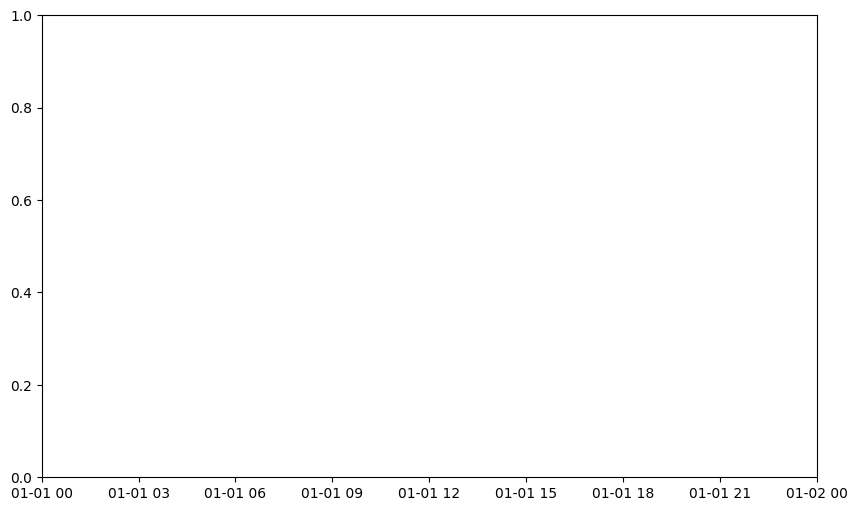

In [ ]:
def forecast_future(model, last_sequence, n_days, window_size):
    predictions = []
    current_sequence = last_sequence  # (1, window_size, 3) - 3 features: booking_count, temperature, is_weekend
    for _ in range(n_days):
        # Make prediction (only for booking_count)
        pred = model.predict(current_sequence)  # pred.shape: (1, 1)
        predictions.append(pred[0, 0])

        # Prepare data for next prediction
        # 1. Get the last values of temperature and is_weekend
        last_temp = current_sequence[0, -1, 1]  # Shape: (1,)
        last_weekend = current_sequence[0, -1, 2]  # Shape: (1,)

        # 2. Create a new sequence entry with prediction, last temperature, and last weekend
        new_entry = np.array([[pred[0, 0], last_temp, last_weekend]])  # Shape: (1, 3)

        # 3. Reshape to (1, 1, 3) for concatenation
        new_entry = new_entry.reshape(1, 1, 3)

        # 4. Update the sequence with the new prediction
        current_sequence = np.concatenate([current_sequence[:, 1:, :], new_entry], axis=1)

    return predictions

# Get the last sequence from the test set for forecasting (use the last window of the test data)
last_sequence = X_test[-1:]

# Forecast the next 90 days
forecast_days = 90
predicted_values = forecast_future(model, last_sequence, forecast_days, window_size)

# Inverse transform the predictions to get actual booking counts
predicted_values = scaler_y.inverse_transform(np.array(predicted_values).reshape(-1, 1))

# Create a date range for the next 90 days (starting from the last date in the test set)
last_date = df_station['ds'].iloc[-1]
forecast_dates = pd.date_range(last_date, periods=forecast_days + 1, freq='D')[1:]

# Plot the future predictions
plt.figure(figsize=(10, 6))
plt.plot(df_station['ds'], y_test, label='Actual Test Data', color='blue')
plt.plot(forecast_dates, predicted_values, label='Predicted Future (90 Days)', color='red')
plt.title("90-Day Forecast for Citibike Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare data for ARIMAX (no windowing needed)
train_arimax = train[['y', 'temperature', 'is_weekend']]
val_arimax = validation[['y', 'temperature', 'is_weekend']]
test_arimax = test[['y', 'temperature', 'is_weekend']]

# Fit ARIMAX model (example order - use auto_arima for optimal params)
arimax_model = SARIMAX(train_arimax['y'],
                      exog=train_arimax[['temperature', 'is_weekend']],
                      order=(2,1,2),  # (p,d,q)
                      seasonal_order=(1,1,1,7))  # Weekly seasonality

arimax_fit = arimax_model.fit(disp=False)

# Forecast validation set
arimax_val_pred = arimax_fit.forecast(steps=len(val_arimax),
                                     exog=val_arimax[['temperature', 'is_weekend']])

# Forecast test set
arimax_test_pred = arimax_fit.forecast(steps=len(test_arimax),
                                      exog=test_arimax[['temperature', 'is_weekend']])

# Inverse transformations
arimax_val_pred = np.expm1(scaler_y.inverse_transform(arimax_val_pred.values.reshape(-1,1)))
arimax_test_pred = np.expm1(scaler_y.inverse_transform(arimax_test_pred.values.reshape(-1,1)))

# Evaluation (use same metrics as LSTM)
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, mae, rmse, mape

# Compare results
print("LSTM Validation:", evaluate_model(y_val, y_pred_val))
print("ARIMAX Validation:", evaluate_model(validation['y'].values[-len(arimax_val_pred):], arimax_val_pred))

print("\nLSTM Test:", evaluate_model(y_test, y_pred_test))
print("ARIMAX Test:", evaluate_model(test['y'].values[-len(arimax_test_pred):], arimax_test_pred))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

LSTM Validation: (0.1669660365078672, 0.3308719019937975, 0.4086147776425459, np.float64(11.812875602073772))
ARIMAX Validation: (14091655963198.312, 3308801.779496319, 3753885.4488647245, np.float64(112011693.76237608))

LSTM Test: (0.11189119160167751, 0.26953654059993537, 0.33450140747338797, np.float64(8.705883986403624))
ARIMAX Test: (17362657962699.895, 3955821.455337001, 4166852.284722833, np.float64(124155162.27611995))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


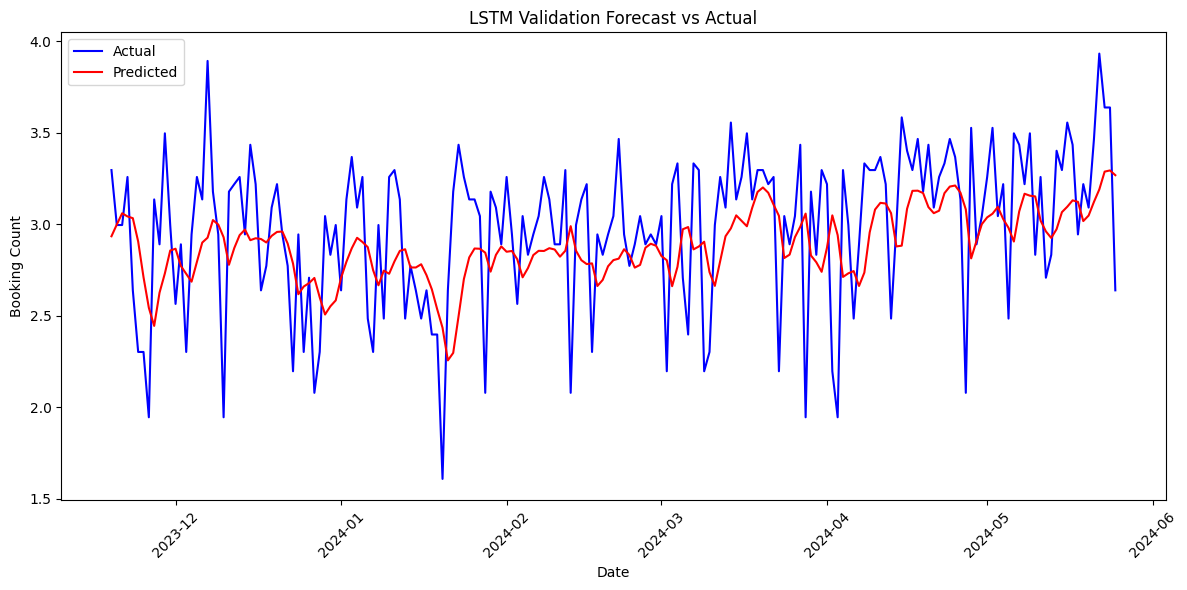

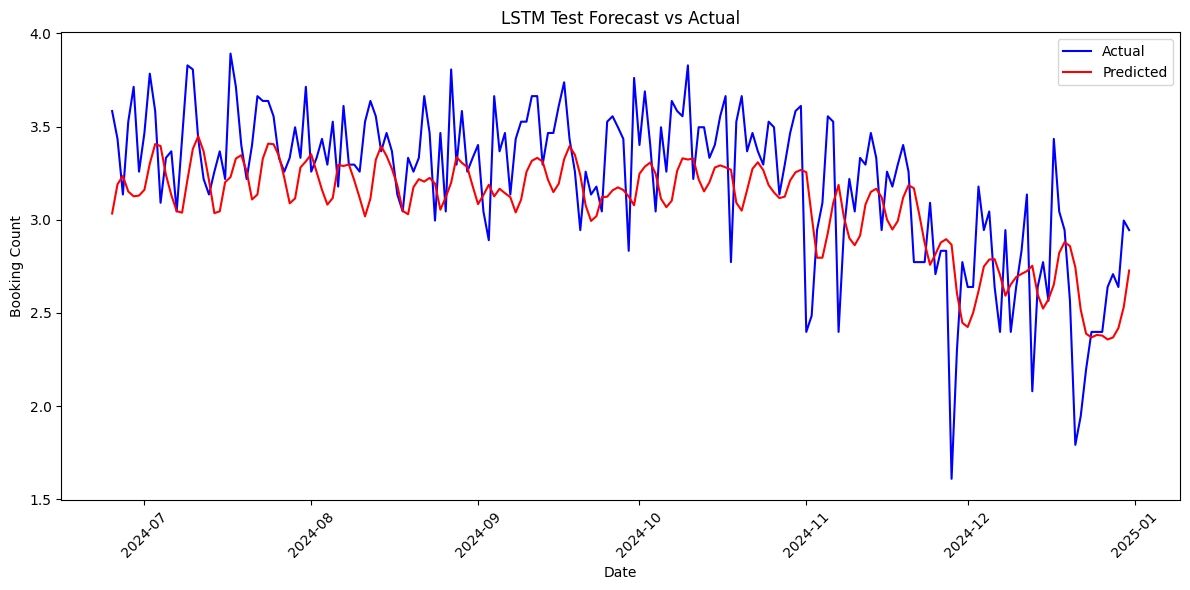

In [ ]:
import matplotlib.pyplot as plt

def plot_comparison_with_dates(dates, actual, pred, title):
    plt.figure(figsize=(12,6))
    plt.plot(dates, actual, label='Actual', color='blue')
    plt.plot(dates, pred, label='Predicted', color='red')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Booking Count")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

dates_val_lstm = validation['ds'].values[-len(y_pred_val):]
dates_test_lstm = test['ds'].values[-len(y_pred_test):]

plot_comparison_with_dates(dates_val_lstm, y_val, y_pred_val, "LSTM Validation Forecast vs Actual")
plot_comparison_with_dates(dates_test_lstm, y_test, y_pred_test, "LSTM Test Forecast vs Actual")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


ValueError: x and y must have same first dimension, but have shapes (219,) and (189, 1)

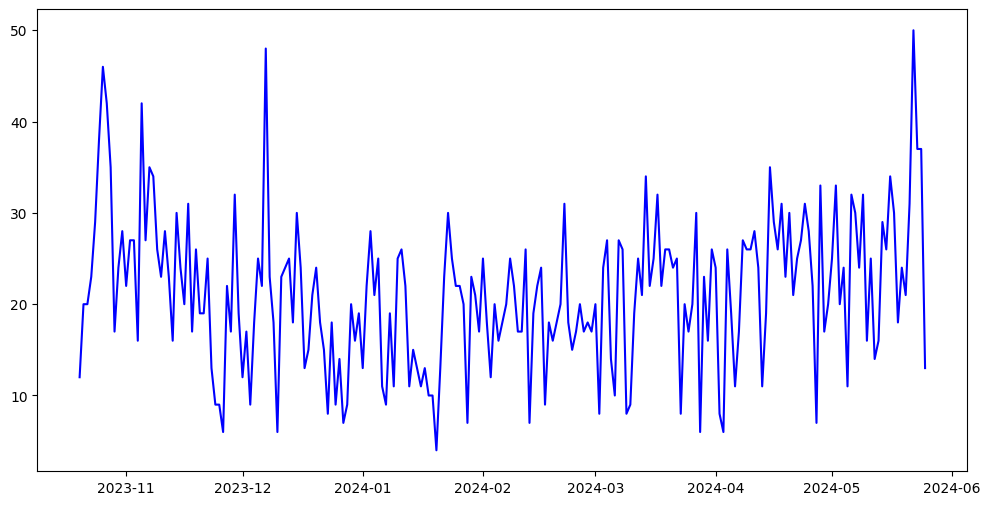

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# ... (your existing code for loading data, preprocessing, and model training) ...

# Forecast 90 days into the future
future_dates = pd.date_range(start=df_station['ds'].max(), periods=90, freq='D')
future_df = pd.DataFrame({'ds': future_dates})

# Prepare future exogenous features (temperature and is_weekend)
# You might need to use historical averages or some other method for these
# For example, using the average of the last 30 days:
future_df['temperature'] = scaler_temp.transform(np.array([df_station['temperature'][-30:].mean()] * 90).reshape(-1, 1))
future_df['is_weekend'] = future_df['ds'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
future_df['is_weekend'] = scaler_weekend.transform(future_df[['is_weekend']])

# Create sequences for future prediction
future_data_y = np.concatenate([train_scaled_y[-window_size:], validation_scaled_y, test_scaled_y])  # Include past data
future_data_temp = np.concatenate([train_scaled_temp[-window_size:], validation_scaled_temp, test_scaled_temp])
future_data_weekend = np.concatenate([train_scaled_weekend[-window_size:], validation_scaled_weekend, test_scaled_weekend])

X_future, _ = create_sequences(future_data_y, future_data_temp, future_data_weekend, window_size)
X_future = X_future[-90:].reshape(-1, window_size, 3)  # Reshape for LSTM input

# Make predictions on future data
future_predictions_scaled = model.predict(X_future)
future_predictions = scaler_y.inverse_transform(future_predictions_scaled)  # Invert scaling
future_predictions = np.expm1(future_predictions)  # Invert log transformation


# Plotting the forecasted values with actual values
def plot_comparison_with_dates(dates, actual, pred, title, future_dates=None, future_pred=None):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='blue')
    plt.plot(dates, pred, label='Predicted', color='red')

    if future_dates is not None and future_pred is not None:
        plt.plot(future_dates, future_pred, label='Future Predicted', color='green', linestyle='--')

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Booking Count")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# ... (your existing code) ...

# Get actual booking counts (inverted from log transformation)
y_val_actual = np.expm1(validation['y'])
y_test_actual = np.expm1(test['y'])

# Use the length of y_val_actual and y_test_actual to slice the dates
dates_val_lstm = validation['ds'].values[-len(y_val_actual):]  # Changed line
dates_test_lstm = test['ds'].values[-len(y_test_actual):]  # Changed line

# Plot with actual booking counts and future predictions
plot_comparison_with_dates(
    dates_val_lstm,
    y_val_actual,
    np.expm1(y_pred_val),  # Invert log transformation for predictions
    "LSTM Validation Forecast vs Actual",
    future_dates=future_dates,
    future_pred=future_predictions
)
plot_comparison_with_dates(
    dates_test_lstm,
    y_test_actual,
    np.expm1(y_pred_test),  # Invert log transformation for predictions
    "LSTM Test Forecast vs Actual",
    future_dates=future_dates,
    future_pred=future_predictions
)

# SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example: weekly seasonality (m=7)
sarimax_model = SARIMAX(train['y'],
                        exog=train[['temperature', 'is_weekend']],
                        order=(2, 1, 2),
                        seasonal_order=(1, 1, 1, 7))
sarimax_fit = sarimax_model.fit(disp=False)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

In [ ]:
# Forecast validation set
val_pred = sarimax_fit.get_forecast(steps=len(validation),
                                   exog=validation[['temperature', 'is_weekend']])
val_pred_mean = val_pred.predicted_mean

# Inverse transform if needed
val_pred_mean = scaler_y.inverse_transform(val_pred_mean.values.reshape(-1,1))
y_val_actual = scaler_y.inverse_transform(validation['y'].values.reshape(-1,1))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Forecast test set
test_pred = sarimax_fit.get_forecast(steps=len(test),
                                    exog=test[['temperature', 'is_weekend']])
test_pred_mean = test_pred.predicted_mean

# Inverse transform
test_pred_mean = scaler_y.inverse_transform(test_pred_mean.values.reshape(-1,1))
y_test_actual = scaler_y.inverse_transform(test['y'].values.reshape(-1,1))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


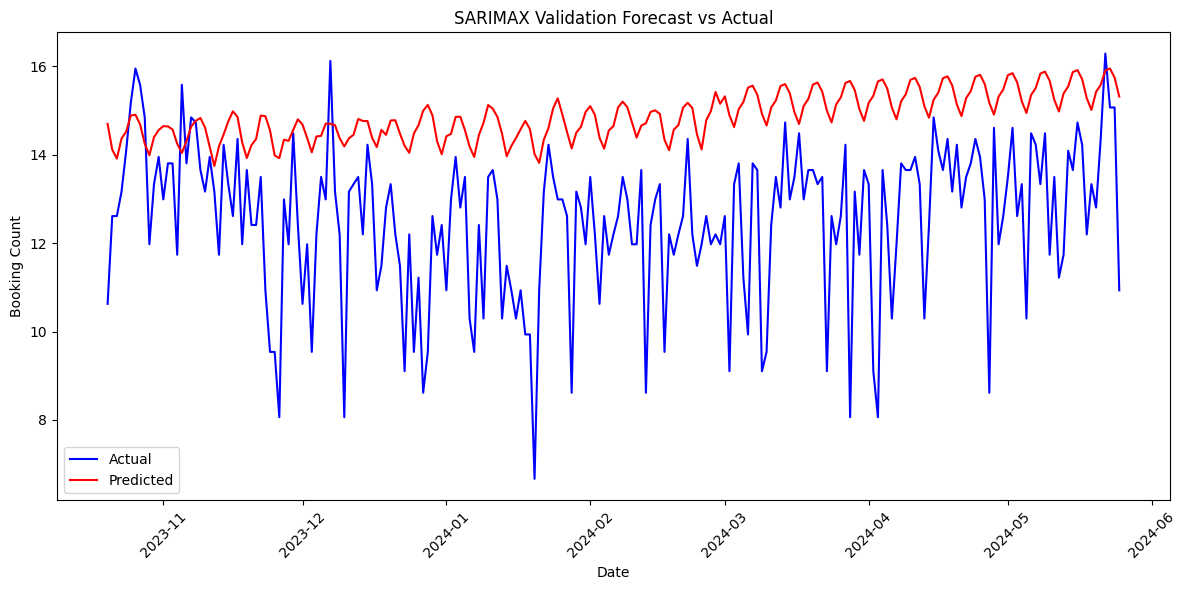

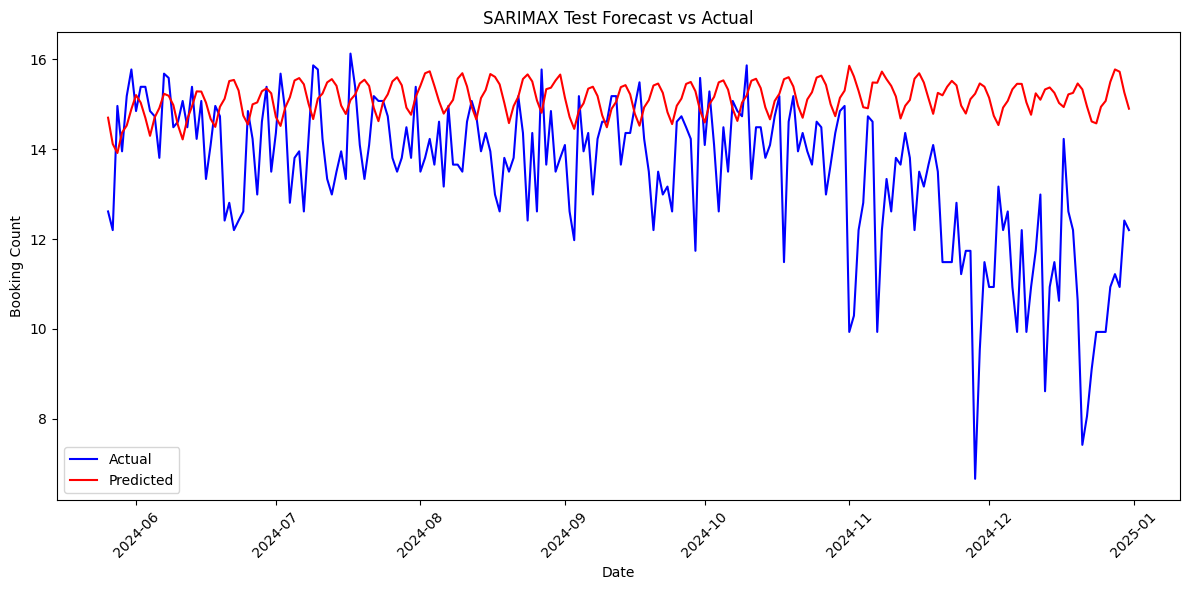

In [ ]:
def plot_comparison_with_dates(dates, actual, pred, title):
    plt.figure(figsize=(12,6))
    plt.plot(dates, actual, label='Actual', color='blue')
    plt.plot(dates, pred, label='Predicted', color='red')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Booking Count")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot validation
plot_comparison_with_dates(validation['ds'], y_val_actual, val_pred_mean, "SARIMAX Validation Forecast vs Actual")

# Plot test
plot_comparison_with_dates(test['ds'], y_test_actual, test_pred_mean, "SARIMAX Test Forecast vs Actual")


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def print_metrics(actual, pred, set_name):
    mse = mean_squared_error(actual, pred)
    mae = mean_absolute_error(actual, pred)
    rmse = sqrt(mse)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100

    print(f"\n{set_name} Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

print_metrics(y_val_actual, val_pred_mean, "Validation")
print_metrics(y_test_actual, test_pred_mean, "Test")



Validation Metrics:
MSE: 8.24
MAE: 2.42
RMSE: 2.87
MAPE: 21.72%

Test Metrics:
MSE: 5.96
MAE: 1.84
RMSE: 2.44
MAPE: 15.74%


# PRophet

In [ ]:
print(sarimax_fit.summary())


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1022
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood                -576.925
Date:                             Fri, 02 May 2025   AIC                           1171.851
Time:                                     01:54:37   BIC                           1216.146
Sample:                                          0   HQIC                          1188.674
                                            - 1022                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.0047      0.002      2.476      0.013       0.001       0.008
is_weekend    -6.5e-08  

<ipython-input-29-429ffe43dd05>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station['DATE'] = pd.to_datetime(df_station['DATE'], errors='coerce')
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm5kb6e50/e0lfq473.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm5kb6e50/852zr76l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47709', 'data', 'file=/tmp/tmpm5kb6e50/e0lfq473.json', 'init=/tmp/tmpm5kb6e50/852zr76l.json', 'output', 'file=/tmp/tmpm5kb6e50/prophet_modelfqke_irr/prophet_model-202505020207

Validation Set Evaluation Metrics:
MSE: 301.715088672584
MAE: 14.22117212455398
RMSE: 17.369947860387608
MAPE: 89.53778180671769%

Test Set Evaluation Metrics:
MSE: 1127.1650802515535
MAE: 30.764143273364162
RMSE: 33.573279259726085
MAPE: 93.20073459695169%


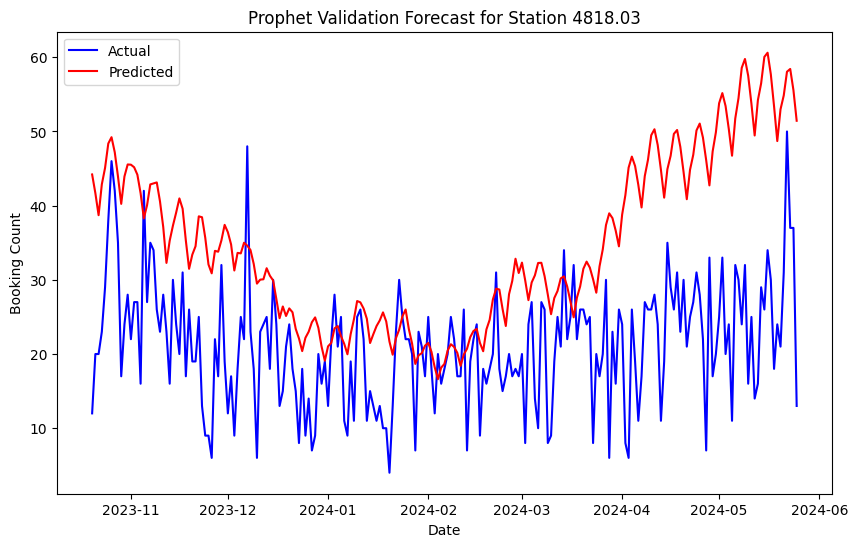

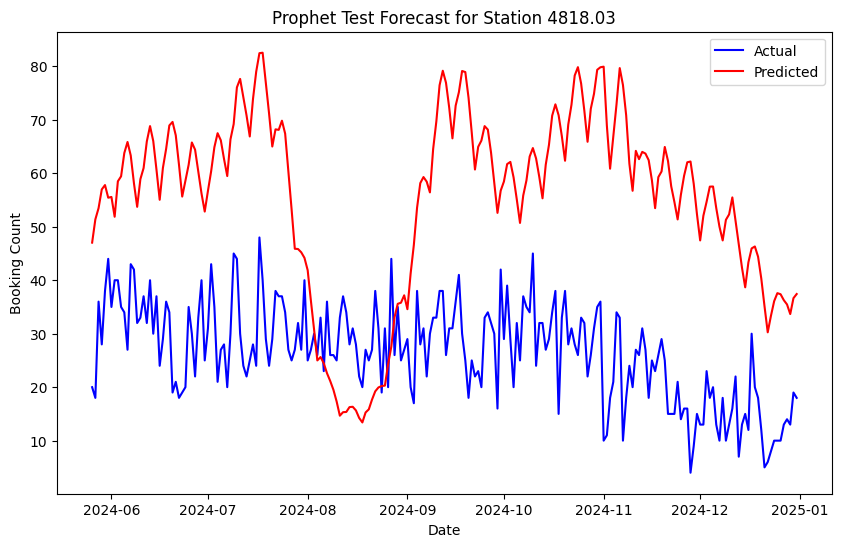

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Load the datasets
file_paths = [
    "/content/2021Citibike daily trip counts&weather.csv",
    "/content/2022Citibike daily trip counts&weather.csv",
    "/content/2023Citibike daily trip counts&weather.csv",
    "/content/2024Citibike daily trip counts&weather.csv",
    "/content/Final_Urban_Feaatures_Merged_csv.csv"
]

# Load each CSV file
df_2021 = pd.read_csv(file_paths[0], dtype={'start_station_id': str})
df_2022 = pd.read_csv(file_paths[1], dtype={'start_station_id': str})
df_2023 = pd.read_csv(file_paths[2], dtype={'start_station_id': str})
df_2024 = pd.read_csv(file_paths[3], dtype={'start_station_id': str})
df_urban = pd.read_csv(file_paths[4])

# Combine the Citibike trip data for all years
df = pd.concat([
    df_2021[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2022[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2023[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2024[['start_station_id', 'DATE', 'booking_count', 'TAVG']]
])

# Filter the data for station 4818.03 only
df_station = df[df['start_station_id'] == '4818.03']

# Convert 'DATE' to datetime format
df_station['DATE'] = pd.to_datetime(df_station['DATE'], errors='coerce')

# Use the 'TAVG' as the temperature column directly
df_station = df_station.dropna(subset=['booking_count', 'DATE'])

# Rename columns to match Prophet input format
df_station.rename(columns={'DATE': 'ds', 'booking_count': 'y', 'TAVG': 'temperature'}, inplace=True)

# Feature Engineering: Create 'day_of_week' and 'is_weekend' to capture weekly seasonality
df_station['day_of_week'] = df_station['ds'].dt.dayofweek
df_station['is_weekend'] = df_station['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Sort the data by 'ds' (date)
df_station = df_station.sort_values('ds')

# Apply log transformation (log(1+x)) to 'y' (booking count)
df_station['y'] = np.log1p(df_station['y'])

# Split data into training (70%), validation (15%), and test (15%)
train_size = int(0.7 * len(df_station))
val_size = int(0.15 * len(df_station))

train = df_station[:train_size].copy()
validation = df_station[train_size:train_size + val_size].copy()
test = df_station[train_size + val_size:].copy()

# Scale the exogenous variables
scaler_temp = MinMaxScaler()
train.loc[:, 'temperature'] = scaler_temp.fit_transform(train[['temperature']])
validation.loc[:, 'temperature'] = scaler_temp.transform(validation[['temperature']])
test.loc[:, 'temperature'] = scaler_temp.transform(test[['temperature']])

scaler_weekend = MinMaxScaler()
train.loc[:, 'is_weekend'] = scaler_weekend.fit_transform(train[['is_weekend']])
validation.loc[:, 'is_weekend'] = scaler_weekend.transform(validation[['is_weekend']])
test.loc[:, 'is_weekend'] = scaler_weekend.transform(test[['is_weekend']])

# Prepare exogenous regressors for Prophet
exog_train = train[['temperature', 'is_weekend']]
exog_validation = validation[['temperature', 'is_weekend']]
exog_test = test[['temperature', 'is_weekend']]

# Create and fit the Prophet model
model = Prophet()
model.add_regressor('temperature')
model.add_regressor('is_weekend')
model.fit(train[['ds', 'y', 'temperature', 'is_weekend']])

# Make future dataframe for validation and test sets
future_validation = validation[['ds', 'temperature', 'is_weekend']]
future_test = test[['ds', 'temperature', 'is_weekend']]

# Make predictions on validation and test sets
forecast_validation = model.predict(future_validation)
forecast_test = model.predict(future_test)

# Inverse transform the log transformation
forecast_validation['yhat'] = np.expm1(forecast_validation['yhat'])
forecast_test['yhat'] = np.expm1(forecast_test['yhat'])
actual_validation = np.expm1(validation['y'])
actual_test = np.expm1(test['y'])

# Evaluate the model on the validation set
mse_val = mean_squared_error(actual_validation, forecast_validation['yhat'])
mae_val = mean_absolute_error(actual_validation, forecast_validation['yhat'])
rmse_val = sqrt(mse_val)
mape_val = np.mean(np.abs((actual_validation - forecast_validation['yhat']) / actual_validation)) * 100

print(f"Validation Set Evaluation Metrics:")
print(f"MSE: {mse_val}")
print(f"MAE: {mae_val}")
print(f"RMSE: {rmse_val}")
print(f"MAPE: {mape_val}%")

# Evaluate the model on the test set
mse_test = mean_squared_error(actual_test, forecast_test['yhat'])
mae_test = mean_absolute_error(actual_test, forecast_test['yhat'])
rmse_test = sqrt(mse_test)
mape_test = np.mean(np.abs((actual_test - forecast_test['yhat']) / actual_test)) * 100

print(f"\nTest Set Evaluation Metrics:")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"MAPE: {mape_test}%")

# Plot validation results
plt.figure(figsize=(10, 6))
plt.plot(validation['ds'], actual_validation, label='Actual', color='blue')
plt.plot(validation['ds'], forecast_validation['yhat'], label='Predicted', color='red')
plt.title("Prophet Validation Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.show()

# Plot test results
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], actual_test, label='Actual', color='blue')
plt.plot(test['ds'], forecast_test['yhat'], label='Predicted', color='red')
plt.title("Prophet Test Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.show()


# ARIMAX

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

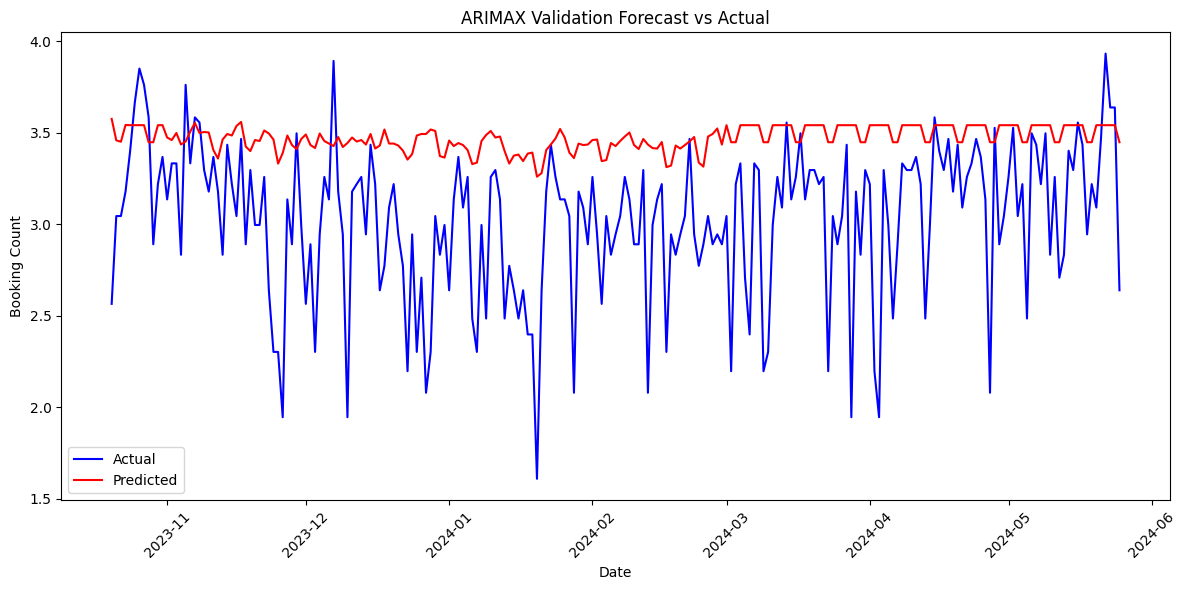

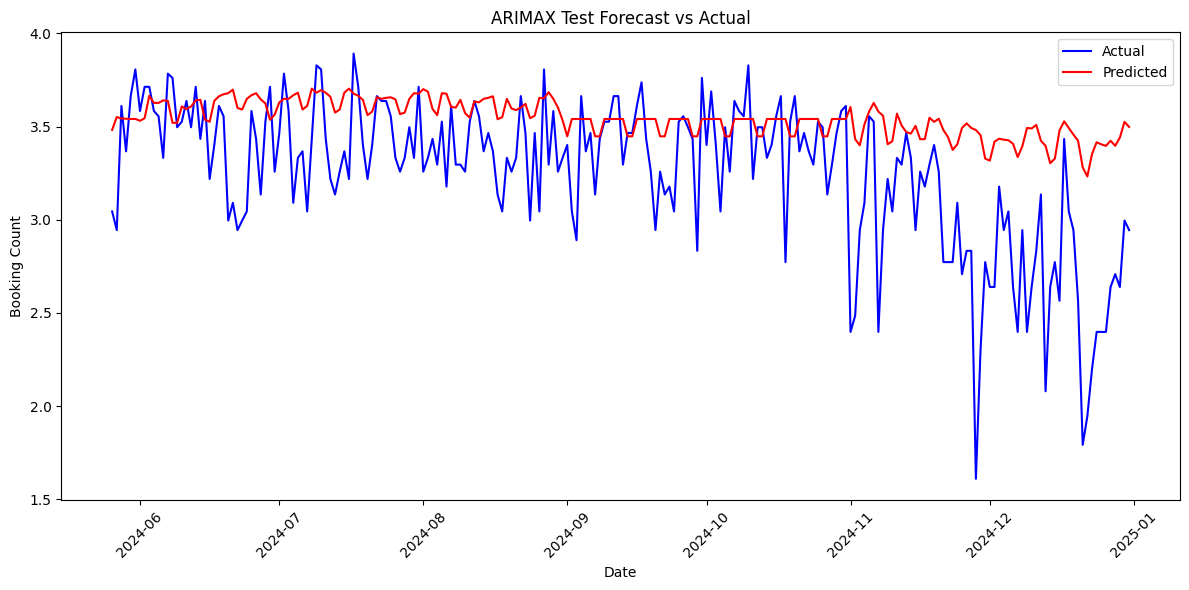


Validation Metrics:
MSE: 0.36
MAE: 0.47
RMSE: 0.60
MAPE: 17.98%

Test Metrics:
MSE: 0.21
MAE: 0.34
RMSE: 0.46
MAPE: 12.10%
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1022
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -566.162
Date:                Fri, 02 May 2025   AIC                           1146.324
Time:                        02:34:11   BIC                           1180.824
Sample:                             0   HQIC                          1159.423
                               - 1022                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.4197      0.142      2.950      0.003       0.141       0.699
is_w

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

# Example: Assume train, validation, test are already defined as in your code
# train, validation, test: DataFrames with columns ['y', 'temperature', 'is_weekend', 'ds']

# Fit ARIMAX model on training data
arimax_model = ARIMA(
    endog=train['y'],
    exog=train[['temperature', 'is_weekend']],
    order=(2, 1, 2)  # Adjust (p, d, q) as needed
)
arimax_fit = arimax_model.fit()

# Forecast validation set
val_pred = arimax_fit.forecast(
    steps=len(validation),
    exog=validation[['temperature', 'is_weekend']]
)

# Forecast test set (only after finalizing model)
test_pred = arimax_fit.forecast(
    steps=len(test),
    exog=test[['temperature', 'is_weekend']]
)

# Convert predictions to numpy arrays (if not already)
val_pred = val_pred.values.reshape(-1, 1)
test_pred = test_pred.values.reshape(-1, 1)

# Inverse transform if you scaled 'y' (as in your LSTM code)
# val_pred = scaler_y.inverse_transform(val_pred)
# test_pred = scaler_y.inverse_transform(test_pred)
# y_val_actual = scaler_y.inverse_transform(validation['y'].values.reshape(-1, 1))
# y_test_actual = scaler_y.inverse_transform(test['y'].values.reshape(-1, 1))

# Plot validation results with dates
plt.figure(figsize=(12, 6))
plt.plot(validation['ds'], validation['y'], label='Actual', color='blue')
plt.plot(validation['ds'], val_pred, label='Predicted', color='red')
plt.title("ARIMAX Validation Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot test results with dates
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual', color='blue')
plt.plot(test['ds'], test_pred, label='Predicted', color='red')
plt.title("ARIMAX Test Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Evaluation metrics function
def print_metrics(actual, pred, set_name):
    # Ensure 'pred' is 1-dimensional
    pred = pred.flatten()  # or pred = pred.reshape(-1)

    mse = mean_squared_error(actual, pred)
    mae = mean_absolute_error(actual, pred)
    rmse = sqrt(mse)

    # Handle potential division by zero in MAPE calculation
    mape = np.mean(np.abs((actual - pred) / actual[actual != 0])) * 100

    print(f"\n{set_name} Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

print_metrics(validation['y'], val_pred, "Validation")
print_metrics(test['y'], test_pred, "Test")

# Model summary
print(arimax_fit.summary())


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

# ... (rest of your code) ...

# Evaluation metrics function
def print_metrics(actual, pred, set_name):
    # Ensure 'pred' is 1-dimensional
    pred = pred.flatten()  # or pred = pred.reshape(-1)

    mse = mean_squared_error(actual, pred)
    mae = mean_absolute_error(actual, pred)
    rmse = sqrt(mse)

    # Handle potential division by zero in MAPE calculation
    mape = np.mean(np.abs((actual - pred) / actual[actual != 0])) * 100

    print(f"\n{set_name} Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

# ... (rest of your code) ...

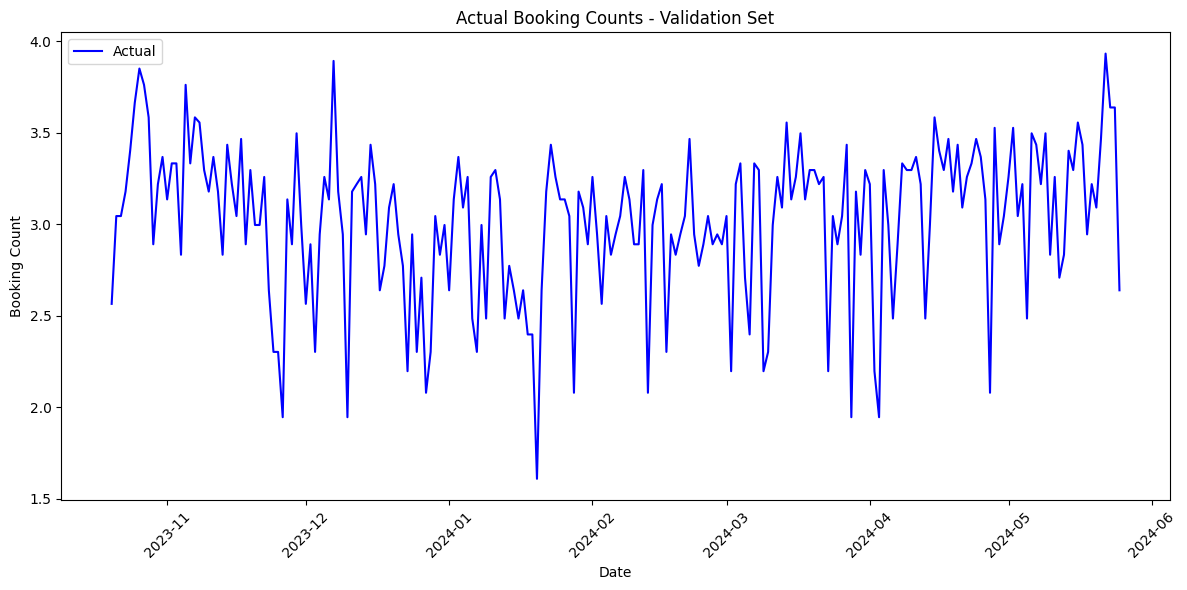

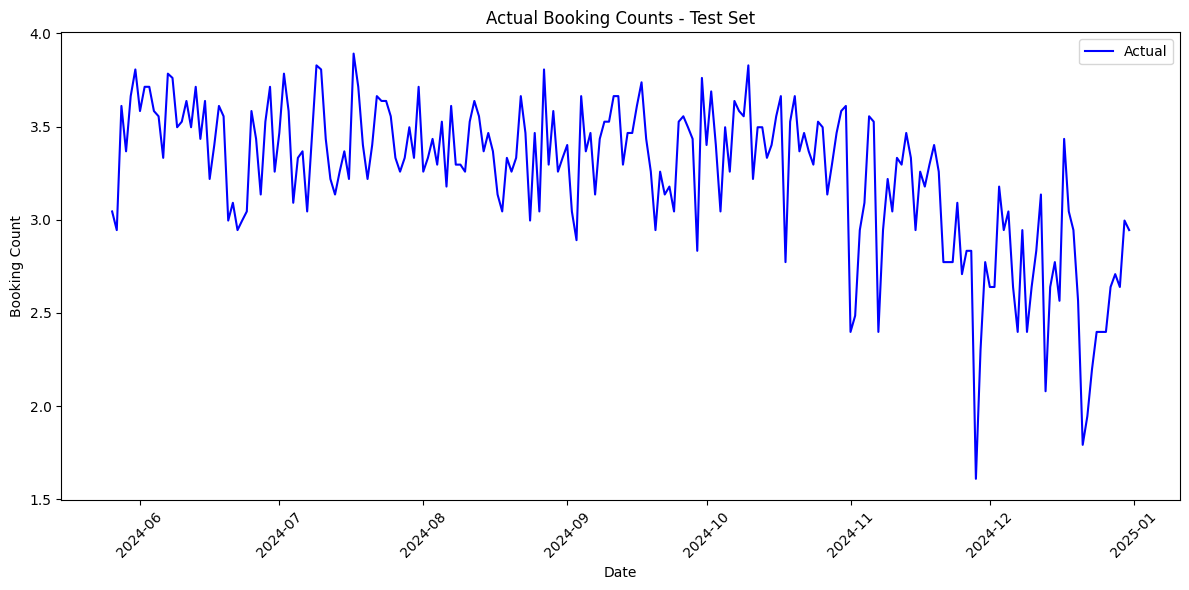

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

# ... (rest of your code) ...


# Function to plot actual booking counts
def plot_actual_booking_counts(dates, actual_counts, title):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_counts, label='Actual', color='blue')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Booking Count")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# ... (After fitting your ARIMA model and making predictions) ...

# Plot actual booking counts for validation set
plot_actual_booking_counts(validation['ds'], validation['y'], "Actual Booking Counts - Validation Set")

# Plot actual booking counts for test set
plot_actual_booking_counts(test['ds'], test['y'], "Actual Booking Counts - Test Set")

# ... (rest of your code) ...